### Хочу сначала отобрать признаки. Признаки с низкой дисперсией скорее всего менее информативны, поэтому, сначала сделаю отбор по дисперсии. В следующем ноутбуке хочу попробовать SBS алгоритм.

In [5]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import tensorly as tl
from tensorly.base import tensor_to_vec,  partial_tensor_to_vec
import pandas as pd
import warnings 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
from glob import glob
import os
import math
import functools
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin

In [2]:
warnings.simplefilter('ignore') # отключим предупреждения Anaconda

In [55]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X_new.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))
print(Xdata_numpy['emission'].shape)

(206,)


In [56]:
Xdata_numpy['excitation']

array([245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350.,
       355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
       410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460.,
       465., 470., 475., 480., 485., 490., 495., 500.])

In [4]:
X_big=Xdata_numpy['X']

In [8]:
(X_big.mean(axis=0)).shape

(206, 52)

In [17]:
X_big[:,50,8]

array([0.65146595, 1.04989102, 0.45439327, 0.83234159, 0.94569607,
       0.87379848, 0.25354816, 1.28721509, 0.75324228, 1.06003262,
       0.41105254, 1.05576681, 1.27723665, 1.4299822 , 1.44627517,
       0.38409103, 1.28565132, 0.71377399, 0.54094439, 0.53461583,
       0.9341003 , 0.98641663, 1.15157006, 0.9252526 , 0.26309461,
       0.62352113, 0.85551931, 0.42271355, 0.5376293 , 0.51435184,
       0.50412126, 0.84849171, 0.71693687, 0.62951692, 0.82833542])

In [18]:
X_big[:,50,8].mean()

0.7995024560851044

In [15]:
X_big[:,50,8]-X_big[:,50,8].mean()

array([-0.14803651,  0.25038856, -0.34510918,  0.03283913,  0.14619361,
        0.07429603, -0.54595429,  0.48771264, -0.04626018,  0.26053016,
       -0.38844991,  0.25626435,  0.47773419,  0.63047974,  0.64677271,
       -0.41541142,  0.48614887, -0.08572846, -0.25855807, -0.26488663,
        0.13459784,  0.18691417,  0.3520676 ,  0.12575014, -0.53640785,
       -0.17598133,  0.05601685, -0.3767889 , -0.26187316, -0.28515062,
       -0.2953812 ,  0.04898926, -0.08256559, -0.16998553,  0.02883296])

In [19]:
(X_big[:,50,8]-X_big[:,50,8].mean())**2

array([0.02191481, 0.06269443, 0.11910035, 0.00107841, 0.02137257,
       0.0055199 , 0.29806609, 0.23786361, 0.00214   , 0.06787596,
       0.15089334, 0.06567142, 0.22822996, 0.39750471, 0.41831494,
       0.17256665, 0.23634072, 0.00734937, 0.06685227, 0.07016493,
       0.01811658, 0.03493691, 0.1239516 , 0.0158131 , 0.28773338,
       0.03096943, 0.00313789, 0.14196988, 0.06857755, 0.08131087,
       0.08725005, 0.00239995, 0.00681708, 0.02889508, 0.00083134])

In [20]:
sum((X_big[:,50,8]-X_big[:,50,8].mean())**2)

3.5842251112831938

In [111]:
class firstSellectionVariables (BaseEstimator):
    def __init__(self, var_excitation=0.01, var_emission=0.2):
        self.var_excitation=var_excitation
        self.var_emission=var_emission
        
    def variance(self, x):
        dispersion=np.zeros([x.shape[1],x.shape[2]])
        for i in range(0, x.shape[1]):
            for j in range(0, x.shape[2]):
                dispersion[i,j]=(1/x.shape[0])*(sum((x[:,i,j]-x[:,i,j].mean())**2))
        self.dispersion=dispersion
        
    def selectionExctationWave(self,x,waveExcitation, waveEmission):
        excitation=dict()
        for i in range(0,x.shape[2]):
            excitation[max(self.dispersion[:,i])]=i
        excitation_var=sorted(excitation, reverse=True)
        sortedExcitation=dict()
        k=0
        while(True):
            if (excitation_var[k] < self.var_excitation):
                break
            sortedExcitation[excitation_var[k]]=excitation[excitation_var[k]]
            k+=1
        print(sortedExcitation)
        wave1=list()
        wave1=sorted(sortedExcitation.values())
        print(wave1)
        x_meta=x[:,:,wave1]
        new_excitation=waveExcitation[wave1]
        plt.imshow(x_meta[5,:,:], aspect='auto')
        plt.show();
        print(new_excitation)
        
        emission=dict()
        for i in range(0, x.shape[1]):
            emission[max(self.dispersion[i,wave1])]=i
        emission_var=sorted(emission, reverse=True)
        #print(emission_var)
        wave2=list()
        k=0
        sortedEmission=dict()
        while(True):
            if (emission_var[k] < self.var_emission):
                break
            sortedEmission[emission_var[k]]=emission[emission_var[k]]
            k+=1
        print(sortedEmission)
        wave2=sorted(sortedEmission.values())
        print(wave2)
        x_new_=x_meta[:,wave2,:]
        new_emission=waveEmission[wave2]
        plt.imshow(x_new_[5,:,:], aspect='auto')
        plt.show();
        print(new_emission)
        self.x_new_=x_new_
        self.new_emission=new_emission
        self.new_excitation=new_excitation
        return self

In [112]:
a=firstSellectionVariables()

In [113]:
a.variance(X_big.copy())

{0.5302252138281708: 5, 0.4906916368453562: 4, 0.4590632894247468: 6, 0.4142525017312679: 3, 0.32874194872720225: 2, 0.293389273191901: 7, 0.2374102236292818: 1, 0.1605522917411513: 0, 0.1382565726010714: 8, 0.0459477572661032: 9, 0.011304033659109633: 10}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


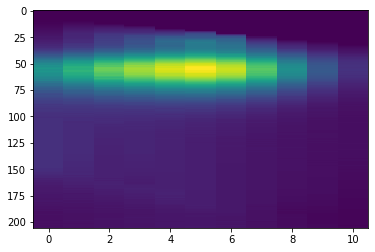

[245. 250. 255. 260. 265. 270. 275. 280. 285. 290. 295.]
{0.5302252138281708: 56, 0.5299276402362565: 57, 0.5214309820476697: 55, 0.5212520817613329: 58, 0.51035744173323: 59, 0.5083296950275183: 54, 0.49831853429375417: 60, 0.4893598477177294: 53, 0.4835469804957803: 61, 0.4701781180310853: 52, 0.4510448355355595: 62, 0.43717840380046336: 51, 0.4226275932892278: 63, 0.4117388888447714: 50, 0.39629883542595856: 64, 0.37956781449345084: 49, 0.36291379486549874: 65, 0.3385677542675956: 48, 0.33137964950887977: 66, 0.299991971510546: 47, 0.2966113772688456: 67, 0.2714299817553319: 68, 0.2602746025051181: 46, 0.24186136357928364: 69, 0.2257531801361496: 45, 0.21563273645158096: 30, 0.21506604228809093: 70, 0.20919899829343677: 31, 0.20664339435035795: 29, 0.20440804251051028: 32}
[29, 30, 31, 32, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


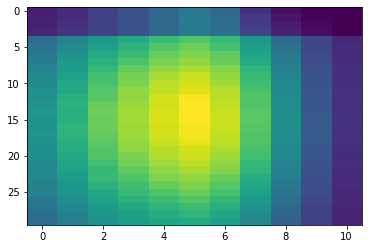

[298. 300. 302. 304. 330. 332. 334. 336. 338. 340. 342. 344. 346. 348.
 350. 352. 354. 356. 358. 360. 362. 364. 366. 368. 370. 372. 374. 376.
 378. 380.]


firstSellectionVariables(var_emission=0.2, var_excitation=0.01)

In [114]:
a.selectionExctationWave(X_big.copy(),Xdata_numpy['excitation'],Xdata_numpy['emission'])